In [8]:
cd /data/projects/windturbine-identification/MachineLearningCourse

/data/projects/windturbine-identification/MachineLearningCourse


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 13:04:17 2019

@author: jschmidt
"""
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import math

import pickle  # pip install dill --user
import matplotlib.pyplot as plt
from keras.applications import VGG16
import tensorflow as tf
#import tensorflow.tfp as tfp

import imp
import scripts.windturbines.functions_pattern_recognition as fpr
imp.reload(fpr)

gpu_fraction = 0.8
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import keras.backend as K

import math

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def mean_true(y_true, y_pred):
    return K.mean(y_true)

def c_metric(y_true, y_pred):
    x = y_true
    y = y_pred
    diff_x = x - K.mean(x)
    diff_y = y - K.mean(y)
    sum_diffs = K.sum(diff_x * diff_y)
    low = K.sqrt(K.sum(diff_x * diff_x)) * K.sqrt(K.sum(diff_y * diff_y))
    metric = sum_diffs / low
    return metric

def c_length(y_true, y_pred):
    length = tf.to_float(tf.size(y_true))
    return length


EG
13
MA
13
ZA
13
CN
13
IN
13
JP
13
KP
13
PK
13
PH
13
TH
13
CR
13
TR
13
AT
13
BE
13
BG
13
HR
13
DK
13
FI
13
FR
13
DE
13
GR
13
IE
13
IT
13
LT
13
NL
13
NO
13
PL
13
PT
13
RO
13
ES
13
SE
13
GB
13
UA
13
CA
13
MX
13
US
13
AU
13
NZ
13
BR
13
CL
13
UY
13
MIX
13
GLOBAL
13
EG
18
MA
18
ZA
18
CN
18
IN
18
JP
18
KP
18
PK
18
PH
18
TH
18
CR
18
TR
18
AT
18
BE
18
BG
18
HR
18
DK
18
FI
18
FR
18
DE
18
GR
18
IE
18
IT
18
LT
18
NL
18
NO
18
PL
18
PT
18
RO
18
ES
18
SE
18
GB
18
UA
18
CA
18
MX
18
US
18
AU
18
NZ
18
BR
18
CL
18
UY
18
MIX
18
GLOBAL
18
EG
19
MA
19
ZA
19
CN
19
IN
19
JP
19
KP
19
PK
19
PH
19
TH
19
CR
19
TR
19
AT
19
BE
19
BG
19
HR
19
DK
19
FI
19
FR
19
DE
19
GR
19
IE
19
IT
19
LT
19
NL
19
NO
19
PL
19
PT
19
RO
19
ES
19
SE
19
GB
19
UA
19
CA
19
MX
19
US
19
AU
19
NZ
19
BR
19
CL
19
UY
19
MIX
19
GLOBAL
19


# Training Phase

In [10]:
COUNTRY = "US"

train_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TYPE_REGRESSION_TRAIN", 18)
test_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TYPE_REGRESSION_TEST", 18)

# Part II: Pretrained model


#conv_base = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(256, 256, 3))

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

#set_trainable = False
#for layer in conv_base.layers:
#    if layer.name == 'block4_conv1':
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False
        
        
        
pd_train = pd.read_csv(train_dir + "list.csv")
pd_test = pd.read_csv(test_dir + "list.csv")

pd_train['power_density'] = pd_train['t_cap'] / (pd_train['t_rd'] * pd_train['t_rd'] * math.pi)  
pd_test['power_density'] = pd_test['t_cap'] / (pd_test['t_rd'] * pd_test['t_rd'] * math.pi)

#pd_train['score'] = pd_train['t_cap'] / np.max(pd_train['t_cap'])
#pd_test['score'] = pd_test['t_cap'] / np.max(pd_test['t_cap'])


param = 't_rd'
pd_train['score'] = pd_train[param] / np.max(pd_train[param])
pd_test['score'] = pd_test[param] / np.max(pd_test[param])


In [11]:
train_dir

'data/aerialImages/GOOGLE/RESOLUTION18/US/type_keras_regression/train/'

In [12]:
pd_train.head()

,Unnamed: 0,id,t_hh,id_s,t_rd,t_cap,power_density,score
0,5,6,23.0,6.png,23.0,160.0,0.096275,0.1840
1,23,24,30.0,24.png,27.0,225.0,0.098244,0.2160
2,25,26,60.0,26.png,61.4,1000.0,0.084433,0.4912
3,29,30,30.0,30.png,39.0,500.0,0.104638,0.3120
4,30,31,24.6,31.png,16.0,65.0,0.080821,0.1280


In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   horizontal_flip = True,
                                   fill_mode = "nearest", 
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   rotation_range = 30,
                                   validation_split = 0.25) 

train_generator = train_datagen.flow_from_dataframe(dataframe = pd_train, 
                                                    directory = train_dir, 
                                                    x_col = "id_s", 
                                                    y_col = "score", 
                                                    has_ext = True, 
                                                    class_mode="other", 
                                                    subset="training",
                                                    batch_size=20)

#                                                    target_size=(img_width, img_height), 


val_generator = train_datagen.flow_from_dataframe(dataframe = pd_train, 
                                                    directory = train_dir, 
                                                    x_col = "id_s", 
                                                    y_col = "score", 
                                                    has_ext = True, 
                                                    class_mode="raw", 
                                                    subset="validation",
                                                    batch_size=20)

#                                                    target_size=(img_width, img_height), 

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe = pd_test, 
                                                    directory = test_dir, 
                                                    x_col = "id_s", 
                                                    y_col = "score", 
                                                    has_ext = True, 
                                                    class_mode="raw", 
                                                    batch_size=20)

Found 27389 validated image filenames.
Found 9129 validated image filenames.
Found 9128 validated image filenames.


In [14]:
model.compile(loss='mean_squared_error',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=[mean_pred, mean_true, c_metric, c_length])

mcp_save = ModelCheckpoint('models/model-regression-unfreezed-2-layer-2-layer-classification-6497-turbines-{epoch:04d}-{val_loss:.4f}.h5',
                           save_best_only=True, monitor='val_loss', mode='min')




In [15]:
#tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=30,
      validation_data=val_generator,
      validation_steps=50,
      callbacks=[mcp_save],
      verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 21s - loss: 0.0747 - mean_pred: 0.5275 - mean_true: 0.6153 - c_metric: 0.0220 - c_length: 20.0000 - val_loss: 0.0391 - val_mean_pred: 0.5775 - val_mean_true: 0.5654 - val_c_metric: -1.5232e-01 - val_c_length: 20.0000
Epoch 2/30
 - 18s - loss: 0.0431 - mean_pred: 0.5907 - mean_true: 0.6119 - c_metric: 0.0691 - c_length: 20.0000 - val_loss: 0.0551 - val_mean_pred: 0.6696 - val_mean_true: 0.5670 - val_c_metric: -1.6882e-01 - val_c_length: 20.0000
Epoch 3/30
 - 19s - loss: 0.0417 - mean_pred: 0.6025 - mean_true: 0.6156 - c_metric: 0.1147 - c_length: 20.0000 - val_loss: 0.0389 - val_mean_pred: 0.5817 - val_mean_true: 0.5640 - val_c_metric: -1.3626e-01 - val_c_length: 20.0000
Epoch 4/30
 - 19s - loss: 0.0425 - mean_pred: 0.6033 - mean_true: 0.6207 - c_metric: 0.0950 - c_length: 20.0000 - val_loss: 0.0374 - val_mean_pred: 0.5525 - val_mean_true: 0.5657 - val_c_metric: -1.8455e-01 - val_c_length: 20.0000
Epoch 5/30
 - 21s - loss: 0.

# Validation vs. Training

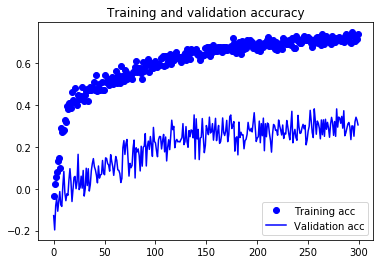

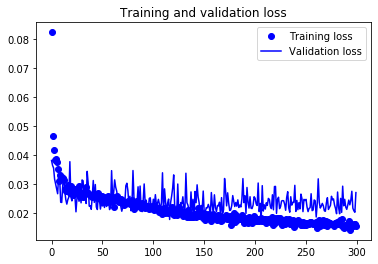

In [27]:
acc = history.history['c_metric']
val_acc = history.history['val_c_metric']
#acc = history.history['acc']
#val_acc = history.history['val_acc']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# Model selection

In [28]:
min_val_loss = min(val_loss)

i = val_loss.index(min_val_loss) + 1

best_model = "models/model-regression-unfreezed-2-layer-2-layer-classification-6497-turbines-" + "{0:0=4d}".format(i) + "-" + "{0:.4f}".format(min_val_loss) + ".h5"

#best_model = "models/model-regression-unfreezed-2-layer-2-layer-classification-6497-turbines-0029-0.0218.h5"

best_model

'models/model-regression-unfreezed-2-layer-2-layer-classification-6497-turbines-0117-0.0177.h5'

# Test

In [29]:
test_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TEST", 18)+"../"

#test_model = models.load_model(best_model)

test_model = model

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = pd_test, 
                                                    directory = test_dir, 
                                                    x_col = "id_s", 
                                                    y_col = "score", 
                                                    has_ext = True, 
                                                    class_mode=None, 
                                                    batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

#test_loss, test_acc = test_model.evaluate_generator(test_generator, steps=32)
#print('test acc:', test_acc)
#print('test loss:', test_loss)


Found 9128 validated image filenames.


In [30]:
predict
pd_test['predict'] = predict

In [31]:
pd_test.head()

,Unnamed: 0,id,t_hh,id_s,t_rd,t_cap,power_density,score,predict
0,41529,41530,80.0,41530.png,100.0,2000.0,0.063662,0.735294,0.757999
1,41530,41531,80.0,41531.png,100.0,2000.0,0.063662,0.735294,0.588120
2,41531,41532,80.0,41532.png,100.0,2000.0,0.063662,0.735294,0.862283
3,41532,41533,80.0,41533.png,100.0,2000.0,0.063662,0.735294,0.780256
4,41533,41534,80.0,41534.png,100.0,2000.0,0.063662,0.735294,0.709472


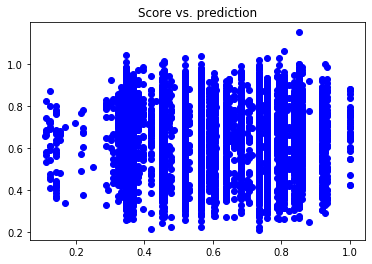

In [32]:
plt.figure()

plt.plot(pd_test['score'], pd_test['predict'], 'bo', label='Training loss')
plt.title('Score vs. prediction')

plt.show()